### t-SNE + DBSCAN
- t-SNE 참고 자료
    - https://yamalab.tistory.com/118
    - https://gaussian37.github.io/ml-concept-t_sne/
    - https://skyeong.net/284

- DBSCAN 참고 자료
    - https://todayisbetterthanyesterday.tistory.com/62https://todayisbetterthanyesterday.tistory.com/62
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 필요한 패키지 임포트

In [ ]:
# 데이터 분석
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 군집화
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE                                   # 차원 축소
from sklearn.preprocessing import StandardScaler, MinMaxScaler      # 정규화 
from sklearn.cluster import DBSCAN                                  # 비지도 학습 - 클러스터링 ; DBSCAN
from sklearn import metrics

# csv 파일 저장
import csv
import time
import datetime

### 데이터 불러오기

In [ ]:
file_path = "/content/drive/MyDrive/음성분석공부/모델 구상 단계/음악 장르 분류기/DB Insert/all_features.csv"

df_soundwave = pd.read_csv(file_path, index_col=0)

df_soundwave.shape

(26413, 194)

In [ ]:
df_soundwave.tail(3)

,song,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,...,mfcc_18_std,mfcc_18_kurtosis,mfcc_18_skew,mfcc_19_max,mfcc_19_min,mfcc_19_mean,mfcc_19_std,mfcc_19_kurtosis,mfcc_19_skew,tempo
26410,희망사항-변진섭.wav,6626.547714,222.569192,1675.250386,768.582808,7.601755,2.076598,9679.174805,139.965820,3225.478223,...,8.498595,0.324753,0.143889,25.274963,-39.102985,-3.959477,8.316226,0.225963,-0.079749,123.046875
26411,흥탄소년단-방탄소년단.wav,7395.957694,795.128559,3298.893197,878.884062,2.785281,1.175508,9959.106445,1108.959961,7124.732163,...,7.922538,0.515741,0.294238,40.800110,-25.855366,2.086992,8.714650,0.176449,0.238497,117.453835
26412,진격의 방탄-방탄소년단.wav,7274.274595,728.096593,2560.988025,696.419143,5.597820,1.583822,9829.907227,96.899414,5297.199567,...,6.711425,0.720385,0.114890,29.026794,-31.096420,1.123931,7.634405,0.500018,0.033145,117.453835


### 데이터 전처리

In [ ]:
df_soundwave.duplicated(subset=['song']).sum()  # 중복값 확인

0

In [ ]:
#df_soundwave.drop_duplicates(subset=['song'], inplace=True, ignore_index=True)  # 중복값 삭제

### 정규화 - Standardscaler

In [ ]:
# StandardScaler 객체 생성
#scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
#df_scaler = df_soundwave.iloc[:, 1:]    # song 컬럼 제외하고 표준화 진행
#scaler.fit(df_scaler)                   # 데이터 분포가 정규분포를 만족하도록 모델을 학습
#df_scaled = scaler.transform(df_scaler) # 정규 분포에 따르는 데이터 값을 ndarray 형식으로 받기

# transform( )시 scale 변환된 데이터셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
#columns = df_soundwave.columns[1:]      # 밑에 변환할 때 리스트 값으로 넣어줘야함
#df_sw = pd.DataFrame(data=df_scaled, columns=columns)

In [ ]:
# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# MinMaxScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
df_scaler = df_soundwave.iloc[:, 1:]    # song 컬럼 제외하고 표준화 진행
scaler.fit(df_scaler)                   # 데이터 범위가 [0, 1]이 되도록 최솟값은 0, 최댓값은 1을 갖도록 모델을 학습
df_scaled = scaler.transform(df_scaler) # [0, 1] 범위에 따르도록 데이터 값을 ndarray 형식으로 받기

# transform( )시 scale 변환된 데이터셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
columns = df_soundwave.columns[1:]      # 밑에 변환할 때 리스트 값으로 넣어줘야함
df_sw = pd.DataFrame(data=df_scaled, columns=columns)

In [ ]:
df_sw       # scaled df

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_18_std,mfcc_18_kurtosis,mfcc_18_skew,mfcc_19_max,mfcc_19_min,mfcc_19_mean,mfcc_19_std,mfcc_19_kurtosis,mfcc_19_skew,tempo
0,0.564473,0.093127,0.440072,0.362261,0.007576,0.109152,0.849951,0.033384,0.473779,0.505612,...,0.314308,0.179074,0.473256,0.276724,0.638365,0.488102,0.277986,0.235298,0.447576,0.336471
1,0.630947,0.087436,0.476952,0.432431,0.008101,0.149245,0.860809,0.033384,0.567992,0.558365,...,0.419482,0.206946,0.495643,0.371104,0.634246,0.540646,0.258525,0.254180,0.461534,0.516176
2,0.602883,0.130402,0.339455,0.309348,0.018955,0.211070,0.863771,0.078907,0.358169,0.418389,...,0.474076,0.251417,0.601649,0.423703,0.452321,0.505678,0.381251,0.317104,0.373609,0.216667
3,0.603528,0.206316,0.379996,0.378360,0.014414,0.207953,0.843040,0.069803,0.404485,0.493862,...,0.485367,0.204200,0.553324,0.544876,0.632899,0.680175,0.371370,0.291088,0.528909,0.308824
4,0.505080,0.224289,0.250444,0.205096,0.039737,0.304520,0.859822,0.098634,0.211137,0.294605,...,0.371845,0.271931,0.632244,0.501553,0.684580,0.458315,0.313687,0.413152,0.759531,0.366422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26408,0.606906,0.107522,0.507974,0.463774,0.005870,0.140564,0.867720,0.039454,0.551747,0.560395,...,0.325450,0.193815,0.487294,0.292129,0.646874,0.509855,0.253743,0.262828,0.436277,0.259454
26409,0.646102,0.282060,0.464923,0.467314,0.005870,0.147907,0.837117,0.156297,0.482916,0.623657,...,0.421610,0.265303,0.650869,0.584543,0.518856,0.643735,0.360491,0.336147,0.632070,0.473389
26410,0.638468,0.079818,0.382054,0.367997,0.014703,0.194943,0.887463,0.019727,0.384064,0.467254,...,0.387980,0.187598,0.505081,0.284206,0.507626,0.441387,0.309858,0.247806,0.430267,0.473389
26411,0.712601,0.285149,0.752338,0.420809,0.008023,0.145238,0.913129,0.156297,0.848357,0.326947,...,0.361682,0.198374,0.538673,0.458779,0.674436,0.596139,0.324703,0.244002,0.516009,0.434492


In [ ]:
# MinMaxScaler 객체 생성
#scaler = MinMaxScaler()

# MinMaxScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
#df_scaler = df_soundwave.iloc[:, 1:]    # song 컬럼 제외하고 표준화 진행
#scaler.fit(df_scaler)                   # 데이터 범위가 [0, 1]이 되도록 최솟값은 0, 최댓값은 1을 갖도록 모델을 학습
#df_scaled = scaler.transform(df_scaler) # [0, 1] 범위에 따르도록 데이터 값을 ndarray 형식으로 받기

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
#columns = df_soundwave.columns[1:]      # 밑에 변환할 때 리스트 값으로 넣어줘야함
#df_sw = pd.DataFrame(data=df_scaled, columns=columns)

### PCA

In [ ]:
# PCA 로 차원 축소를 먼저 하자....
n_components = 2   
random_state = 2022

pca = PCA(n_components=n_components, random_state=random_state)

X_PCA = pca.fit_transform(df_sw)        
X_PCA = pd.DataFrame(data=X_PCA, index=df_sw.index)

X_PCA_inverse = pca.inverse_transform(X_PCA)
X_PCA_inverse = pd.DataFrame(data=X_PCA_inverse, index=df_sw.index)

In [ ]:
X_PCA

,0,1
0,-0.040260,0.294191
1,0.163676,0.211377
2,0.375079,0.090284
3,0.550104,-0.289662
4,1.394662,0.152939
...,...,...
26408,-0.509236,0.133270
26409,0.746035,-0.052758
26410,0.197125,-0.256710
26411,-0.652888,0.536737


### t-SNE 
- 차원 축소
- 참고 자료
    - https://gaussian37.github.io/ml-concept-t_sne/
    - https://runebook.dev/ko/docs/scikit_learn/modules/generated/sklearn.manifold.tsne

In [ ]:
n_components = 2                # 2차원으로 차원 축소 / n_components : 차원 축소 결과 임베딩되는 차원
learning_rate = 300             # 학습을 할 때 사용하는 learning rate (일반적으로 10~1000 사이의 값)
perplexity = 30                 # 다른 manifold learning의 nearest neighbors 갯수에 사용되는 값 (5~50 사이의 값을 선택 -> 값을 변경해가면서 조정할 필요 있음)
early_exaggeration = 12         # 기존 공간에서 데이터의 클러스터 간 거리가 타겟 공간에서 얼만큼 조밀하거나 먼지 나타내는 파라미터
init = 'random'                     # pca 옵션도 존재 ... 뭔지 더 찾아보자..!!!!!!!!!!!
n_iter = 1000                   # 최적화를 위한 최대 반복 횟수 (최소 250이상이어야 학습하는 데 지장 없음)
#n_iter_without_progress        # 성능 개선 없이 학습이 지속되면 학습을 중지하는 옵션이며 카운트는 50의 배수 단위로 카운트
random_state = 2022             # 

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate,
            perplexity=perplexity, early_exaggeration=early_exaggeration,
            init=init, random_state=random_state)

#tSNE = tSNE.fit_transform(df_soundwave.iloc[:, 1:])
tSNE = tSNE.fit_transform(X_PCA)

tSNE_df = pd.DataFrame(tSNE, columns = ['X', 'Y'])

In [ ]:
tSNE_df

,X,Y
0,-34.006653,-12.413354
1,-54.544849,11.148540
2,-45.455883,33.583046
3,17.170425,71.054527
4,-73.172180,66.244835
...,...,...
26408,26.455114,-84.335960
26409,-39.074928,71.767197
26410,30.829241,43.805737
26411,-25.038601,-77.160355


### tSNE 결과 시각화

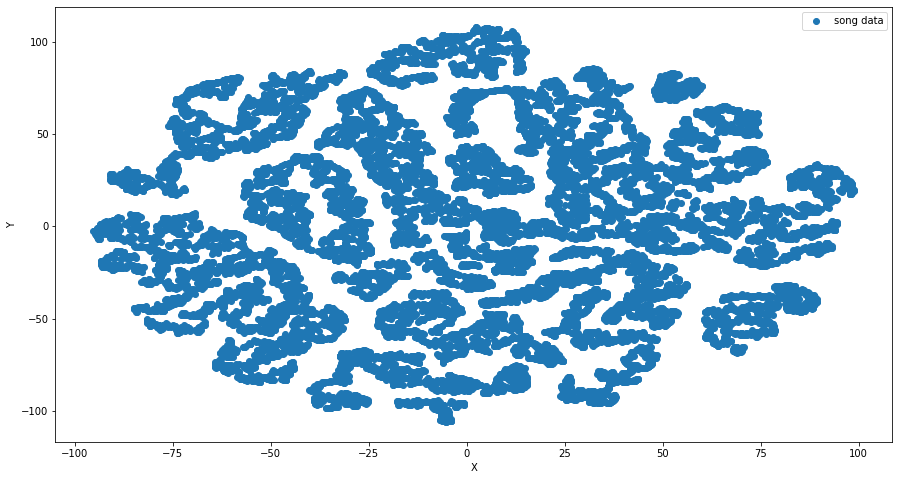

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(tSNE_df.iloc[:,0], tSNE_df.iloc[:,1], label='song data')
plt.legend(loc = 'best')
plt.xlabel('X')
plt.ylabel('Y')
plt.show();

### DBSCAN
- 참고 자료
    - 이론 : https://syj9700.tistory.com/40
    - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
    - https://towardsdatascience.com/understanding-dbscan-and-implementation-with-python-5de75a786f9f

- eps/min_samples : 기본 `3-10` / `3-13` 시도해보기


In [ ]:
# create model and prediction
eps = 2                         # 반지름 # eps : 두 데이터 포인트가 이웃이 되기 위한 조건인 두 포인트 사이의 최대 거리 (매우 중요한 파라미터)
min_samples = 10                # 최소 요소 갯수 # min_samples : 군집이라고 부르기 위한 최소 샘플 -> 최적의 최소 샘플수 찾아야 함!!!!!

model = DBSCAN(eps=eps, min_samples=min_samples).fit(tSNE_df)

predict_fin = pd.DataFrame(model.fit_predict(tSNE_df))           
predict_fin.columns=['predict']                                 

# concatenate labels to df as a new column
dbscan = pd.concat([df_sw, predict_fin], axis=1)

dbscan_song = pd.concat([df_soundwave['song'], predict_fin], axis=1)
dbscan_song

,song,predict
0,How Deep Is Your Love-Bee Gees.wav,0
1,That's Why (You Go Away)-Michael Learns To Roc...,0
2,One Summer Night (Dian Ying << Qiu Xia >> Cha ...,0
3,"My Heart Will Go On (Love Theme from ""Titanic""...",1
4,Bridge Over Troubled Water-Simon & Garfunkel.wav,2
...,...,...
26408,안좋을때 들으면 더 안좋은 노래-형돈ᄋ...,19
26409,제발-이소라.wav,6
26410,희망사항-변진섭.wav,1
26411,흥탄소년단-방탄소년단.wav,22


In [ ]:
# dbscan.drop(columns=['cluster'], inplace=True)

In [ ]:
# the clustering result of the data
model_labels = model.labels_

np.unique(model_labels, axis=0, return_counts=1)    # -1 = 이상치

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 array([  10, 1745, 2631, 1238,  675,  758, 1404,  730,  331,  445,  470,
         618, 3244,  259,  582,  439,  280,   73,  323,   34,  580, 1446,
        2384, 1258, 1479,   11,  447,  145,  390,  145,   91,  347,  178,
         143,  178,   73,   14,  175,   33,   39,   41,   83,  241,   14,
          97,   27,   43,   22]))

In [ ]:
# 군집별 노래 목록 확인
print(dbscan_song.index[dbscan_song['predict'] == 22].tolist())

[150, 188, 211, 223, 227, 228, 232, 251, 313, 372, 401, 426, 449, 458, 473, 512, 535, 542, 577, 582, 598, 606, 617, 679, 681, 692, 706, 739, 767, 775, 776, 786, 811, 817, 819, 833, 852, 853, 871, 874, 875, 881, 897, 902, 906, 907, 909, 914, 920, 923, 925, 927, 930, 931, 944, 948, 952, 954, 962, 972, 975, 978, 1109, 1112, 1141, 1459, 1586, 1609, 1637, 1656, 1699, 1730, 1769, 1772, 1773, 1776, 1900, 1902, 1918, 1943, 2036, 2181, 2182, 2204, 2211, 2218, 2226, 2229, 2238, 2246, 2248, 2256, 2258, 2276, 2308, 2315, 2322, 2390, 2421, 2426, 2436, 2439, 2444, 2463, 2479, 2498, 2499, 2513, 2535, 2536, 2550, 2555, 2560, 2566, 2673, 2687, 2691, 2773, 2778, 2789, 2791, 2832, 2860, 3010, 3071, 3143, 3147, 3169, 3199, 3217, 3227, 3248, 3263, 3294, 3296, 3303, 3310, 3371, 3374, 3380, 3398, 3425, 3461, 3462, 3473, 3485, 3490, 3516, 3520, 3540, 3591, 3593, 3597, 3599, 3605, 3619, 3621, 3623, 3624, 3629, 3630, 3631, 3637, 3678, 3684, 3686, 3701, 3746, 3761, 3765, 3793, 3822, 3834, 3836, 3838, 3852, 3900,

In [ ]:
# 노래 확인
dbscan_song.iloc[14089]['song'], dbscan_song.iloc[14108]['song'], dbscan_song.iloc[14127]['song']

('Electric Shock-f(x).wav',
 'Flashback-애프터스쿨.wav',
 '넘버나인 (No.9)-티아라.wav')

### DBSCAN 성능 평가

In [ ]:
#core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
#core_samples_mask[model.core_sample_indices_] = True

In [ ]:
# 레이블에 있는 클러스터 수, 노이즈가 있을 경우 무시 
#n_clusters = len(set(model_labels)) - (1 if -1 in model_labels else 0) 
#n_noise = list(model_labels).count(-1) 
#
#print('n_clusters_->', n_clusters) 
#print('noise count->', n_noise)
#print('Homogeneity-> %0.3f' % metrics.homogeneity_score(y, model_labels))  # 동질성 -> y 값이 뭐야...?
#print("Completeness: %0.3f" % metrics.completeness_score(y, model_labels)) # 완전성

### DBSCAN 시각화
- 아래 코드 참고 사이트:
    - https://jimmy-ai.tistory.com/138
    - 시각화 : https://jimmy-ai.tistory.com/80

In [ ]:
#.... 일어나면 해보자...

### 군집화 결과 .csv 파일로 변환

In [ ]:
# export the data
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
dbscan_song.to_csv(f'/content/drive/MyDrive/음성분석공부/모델 구상 단계/음악 장르 분류기/DB Insert/dbscan_{filename}.csv')